Collect stock and option data, price with BSM, compare accuracy

In [1]:
import pandas as pd

from math import sqrt
import numpy as np
from scipy.stats import norm

import seaborn as sns

from datetime import datetime, timezone, timedelta


In [2]:
# initial parameters

ticker = 'GOOG'
# risk_free_rate = 0.08
risk_free_rate = 0.04

# 2 weeks, 1m, 3m, 6m
expiration_datetime = datetime(2020, 12, 11, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2020, 12, 24, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2021, 2, 19, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2021, 6, 18, 0, 0, tzinfo=timezone.utc)


In [3]:
# get a UTC timestamp from a date. This is used to scrape data from Yahoo Finance.

expiration_timestamp = int(expiration_datetime.timestamp())

print(expiration_timestamp)
print(datetime.fromtimestamp(expiration_timestamp)) # this is in UTC, add 5 hours to this to get EST

# feb 19 2021

1607644800
2020-12-10 19:00:00


Download historical stock price data for Google (GOOG). I get a past year's worth from (https://finance.yahoo.com/quote/GOOG/history?p=GOOG)

In [4]:
# download annual historical data for the stock

stock_price_path = "~/documents/quant_finance/price_data/{}.csv".format(ticker)
df = pd.read_csv(stock_price_path)
df = df.sort_values(by="Date")
df = df.dropna()

# calculate returns
df = df.assign(close_day_before=df['Adj Close'].shift(1))
df['returns'] = ((df['Adj Close'] - df.close_day_before)/df.close_day_before)

# get options data
options_data_path = 'https://finance.yahoo.com/quote/{}/options?date={}&p={}'.format(ticker, expiration_timestamp, ticker)
options_data = pd.read_html(options_data_path) # returns two dataframes, for calls and puts
r = options_data[0]
calls_df = options_data[1]

print(df)
print(r)

           Date         Open         High          Low        Close  \
0    2019-12-02  1301.000000  1305.829956  1281.000000  1289.920044   
1    2019-12-03  1279.569946  1298.461060  1279.000000  1295.280029   
2    2019-12-04  1307.010010  1325.800049  1304.869995  1320.540039   
3    2019-12-05  1328.000000  1329.358032  1316.439941  1328.130005   
4    2019-12-06  1333.439941  1344.000000  1333.439941  1340.619995   
..          ...          ...          ...          ...          ...   
247  2020-11-23  1749.599976  1753.900024  1717.719971  1734.859985   
248  2020-11-24  1730.500000  1771.599976  1727.689941  1768.880005   
249  2020-11-25  1772.890015  1778.540039  1756.540039  1771.430054   
250  2020-11-27  1773.089966  1804.000000  1772.439941  1793.189941   
251  2020-11-30  1781.180054  1788.064941  1755.010010  1761.329956   

       Adj Close   Volume  close_day_before   returns  
0    1289.920044  1510900               NaN       NaN  
1    1295.280029  1143800       128

In [5]:
# get risk free rate data

rfr_data_path = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
rfr_df = pd.read_html(rfr_data_path)[1] # returns two dataframes, for calls and puts
rfr_df

,Date,1 mo,2 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr,30 yr
0,11/02/20,0.09,0.09,0.09,0.11,0.13,0.16,0.20,0.38,0.63,0.87,1.41,1.63
1,11/03/20,0.09,0.10,0.10,0.12,0.14,0.17,0.21,0.39,0.65,0.90,1.44,1.66
2,11/04/20,0.08,0.09,0.10,0.10,0.12,0.14,0.18,0.33,0.55,0.78,1.33,1.55
3,11/05/20,0.09,0.10,0.10,0.10,0.12,0.14,0.18,0.33,0.56,0.79,1.32,1.54
4,11/06/20,0.10,0.10,0.10,0.11,0.12,0.16,0.21,0.36,0.59,0.83,1.37,1.60
5,11/09/20,0.10,0.10,0.11,0.11,0.12,0.17,0.25,0.44,0.70,0.96,1.51,1.73
6,11/10/20,0.09,0.09,0.10,0.11,0.12,0.19,0.26,0.46,0.72,0.98,1.53,1.75
7,11/12/20,0.10,0.11,0.10,0.10,0.13,0.17,0.23,0.40,0.64,0.88,1.42,1.64
8,11/13/20,0.10,0.09,0.09,0.10,0.12,0.17,0.23,0.41,0.65,0.89,1.43,1.65
9,11/16/20,0.09,0.10,0.09,0.12,0.12,0.19,0.24,0.41,0.66,0.91,1.44,1.66


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'Treasury Curve for 11/30/20'}>

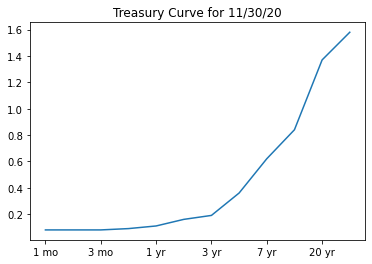

In [6]:
# plot the rfr
rfr_date = rfr_df.iloc[-1][0]

cur_rfr = rfr_df.iloc[-1][1:].astype(float)
cur_rfr.plot(title="Treasury Curve for {}".format(rfr_date))

In [7]:
# BSM model

# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma, option_type='call'):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type=='call':
        return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)
    elif option_type=='put':
        return K*np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
        
# get the (num days to expiration) / (trading days in a year)
def get_time_to_expiration(expiration_datetime_utc):
    return (expiration_datetime_utc - datetime.now(timezone.utc)).days / 252


In [8]:
value_s = black_scholes(S = 69, 
                        K = 70, 
                        T = 6/12, 
                        r = .05, 
                        sigma = .35,
                        option_type='put')
print(value_s)

6.401407649076464


In [9]:
# the rfr should vary with time, not be constant.

cur_stock_price = df.iloc[-1]['Adj Close']
time_to_expiration = get_time_to_expiration(expiration_datetime)

# Calculate the volatility as the annualized standard deviation of the stock returns
sigma = np.sqrt(252) * df['returns'].std()

print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
list_estimates = []

strike_start_idx, strike_end_idx = 0, r.shape[0]
# strike_start_idx, strike_end_idx = 0, 21

# run BSM for different strikes
for x in range(strike_start_idx,strike_end_idx):
    value_s = black_scholes(S = cur_stock_price, 
                            K = r['Strike'][x], 
                            T = time_to_expiration, 
                            r = risk_free_rate, 
                            sigma = sigma)
    list_estimates.append(value_s)
    
# merge the real and computed dataframes to compare results
df_list = pd.DataFrame(data=list_estimates, index=r.index[strike_start_idx:strike_end_idx])
df_list['estimate'] = df_list[0]
del df_list[0]
df_estimate = r.merge(df_list, right_index = True, left_index = True)

cur_stock_price: 1761.3299559999998, time to expiration: 0.03968253968253968, rfr: 0.04, vol: 0.3828343703436754


In [10]:
df_estimate

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate
0,GOOG201211C01000000,2020-11-24 10:57AM EST,1000.0,745.20,752.3,771.5,0.0,-,-,1,135.21%,762.915998
1,GOOG201211C01120000,2020-11-19 3:52PM EST,1120.0,644.20,631.7,651.0,0.0,-,-,9,101.90%,643.106324
2,GOOG201211C01150000,2020-11-19 3:47PM EST,1150.0,614.50,602.7,621.3,0.0,-,-,1,105.84%,613.153905
3,GOOG201211C01170000,2020-11-19 3:47PM EST,1170.0,594.90,583.2,601.2,0.0,-,1,1,104.11%,593.185626
4,GOOG201211C01180000,2020-11-05 10:23AM EST,1180.0,600.12,573.2,591.5,0.0,-,-,1,103.63%,583.201487
...,...,...,...,...,...,...,...,...,...,...,...,...
133,GOOG201211C02120000,2020-11-05 9:30AM EST,2120.0,1.35,0.0,4.4,0.0,-,-,1,54.39%,0.388950
134,GOOG201211C02170000,2020-11-05 10:05AM EST,2170.0,1.65,0.0,4.4,0.0,-,-,2,59.90%,0.150145
135,GOOG201211C02200000,2020-11-27 9:30AM EST,2200.0,0.35,0.0,4.4,0.0,-,1,1,63.10%,0.082533
136,GOOG201211C02550000,2020-11-19 9:59AM EST,2550.0,0.05,0.0,4.3,0.0,-,-,3,95.67%,0.000021


<AxesSubplot:title={'center':'Computed v Market prices for GOOG, Expiry 2020-12-11'}, xlabel='Strike'>

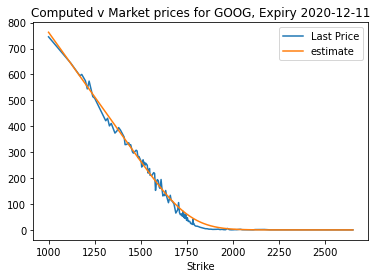

In [11]:
# plot option prices across strikes

df_estimate.plot(x='Strike',y=['Last Price','estimate'], title='Computed v Market prices for {}, Expiry {}'.format(ticker, expiration_datetime.date()))

In [12]:
# def plot_prices_for_dates(date_list):
    
#     for exp_date in date_list:
        
        
#         df_estimate.plot(x='Strike',y=['Last Price','estimate'], title='Computed v Market prices for {}, Expiry {}'.format(ticker, expiration_datetime.date()))

count    1.380000e+02
mean     5.422650e+04
std      6.171092e+05
min     -8.849000e+01
25%     -4.295145e+01
50%     -7.072041e+00
75%      1.136862e+00
max      7.247225e+06
Name: estimate_error, dtype: float64


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


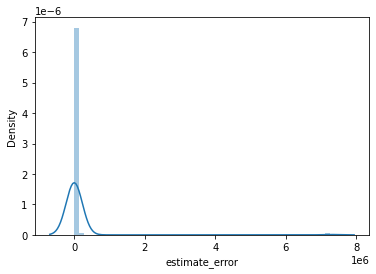

In [13]:
df_estimate['estimate_error'] = ((df_estimate['Last Price'] - df_estimate['estimate'])/df_estimate['estimate'])*100
ax = sns.distplot(df_estimate['estimate_error'])
print(df_estimate['estimate_error'].describe())

# across strikes, the median error is 34%, but there is a huge spread and outliers, 
# which mainly seem to be due to the higher strikes being very close to 0.

In [14]:
# examine outliers

df_estimate[df_estimate['estimate_error'].abs() > 1]

# the model tends to undervalue puts especially at high strikes (deep out of the money).

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate,estimate_error
0,GOOG201211C01000000,2020-11-24 10:57AM EST,1000.0,745.20,752.3,771.5,0.0,-,-,1,135.21%,762.915998,-2.322143e+00
4,GOOG201211C01180000,2020-11-05 10:23AM EST,1180.0,600.12,573.2,591.5,0.0,-,-,1,103.63%,583.201487,2.900972e+00
5,GOOG201211C01200000,2020-11-25 1:43PM EST,1200.0,575.20,552.7,571.0,0.0,-,1,2,94.70%,563.233211,2.124660e+00
6,GOOG201211C01210000,2020-11-19 12:23PM EST,1210.0,544.20,542.7,561.1,0.0,-,-,2,93.43%,553.249075,-1.635624e+00
7,GOOG201211C01220000,2020-11-16 9:47AM EST,1220.0,574.30,533.2,551.1,0.0,-,1,1,94.14%,543.264942,5.712693e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,GOOG201211C02120000,2020-11-05 9:30AM EST,2120.0,1.35,0.0,4.4,0.0,-,-,1,54.39%,0.388950,2.470882e+02
134,GOOG201211C02170000,2020-11-05 10:05AM EST,2170.0,1.65,0.0,4.4,0.0,-,-,2,59.90%,0.150145,9.989384e+02
135,GOOG201211C02200000,2020-11-27 9:30AM EST,2200.0,0.35,0.0,4.4,0.0,-,1,1,63.10%,0.082533,3.240753e+02
136,GOOG201211C02550000,2020-11-19 9:59AM EST,2550.0,0.05,0.0,4.3,0.0,-,-,3,95.67%,0.000021,2.374426e+05


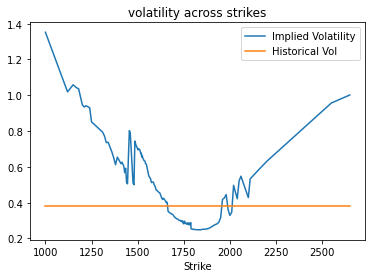

In [15]:
# how accurate are our vol estimates?

df_estimate['Implied Volatility'] = df_estimate['Implied Volatility'].str.replace(',','').str.slice(stop=-1).astype('float') / 100

df_estimate['Historical Vol'] = sigma
ax = df_estimate.plot(x='Strike',y=['Implied Volatility','Historical Vol'],title='volatility across strikes')

<AxesSubplot:title={'center':'volume and open interest'}, xlabel='Strike'>

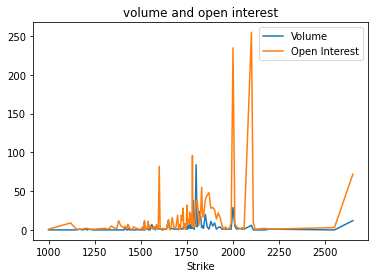

In [16]:
df_estimate['Volume'] = df_estimate['Volume'].replace(to_replace='-',value=0)
df_estimate['Volume'] = df_estimate['Volume'].astype('int')

df_estimate['Open Interest'] = df_estimate['Open Interest'].replace(to_replace='-',value=0)
df_estimate['Open Interest'] = df_estimate['Open Interest'].astype('int')

df_estimate.plot(x='Strike',y=['Volume','Open Interest'],title='volume and open interest')

<AxesSubplot:title={'center':'estimate error across strikes'}, xlabel='Strike'>

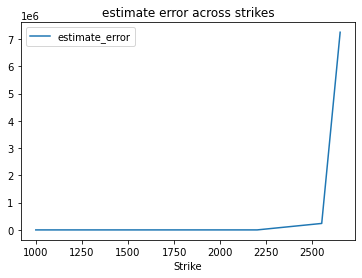

In [17]:
# plot the error across strikes

df_estimate.plot(x='Strike',y='estimate_error',title='estimate error across strikes')


In [18]:
# what is a measure of error?
# MSE: average of the sum of squared errors

mse = np.sum((df_estimate['Last Price'] - df_estimate['estimate'])**2) / df_estimate.shape[0]
rmse = np.sqrt(mse)

print(mse, rmse)
# could also try MAD

249.62256166707047 15.79944814438373


count       137.000000
mean       1722.862686
std       20287.221524
min         -88.490003
25%         -43.181244
50%          -7.081673
75%           0.834385
max      237442.612979
Name: estimate_error, dtype: float64


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Option prices for GOOG, Expiry 2020-12-11 (Filtered Strikes)'}, xlabel='Strike'>

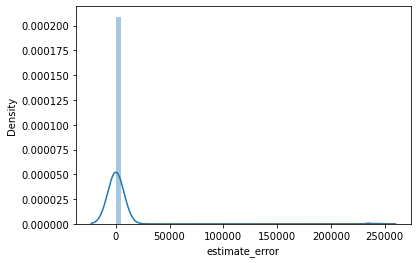

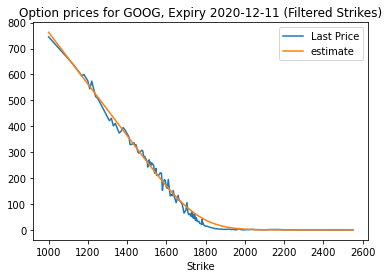

In [19]:
# filter deep ITM and OTM options

lower_bound, upper_bound = cur_stock_price * .5, cur_stock_price * 1.5
put_estimate_filtered = df_estimate[(df_estimate['Strike'] > lower_bound) & (df_estimate['Strike'] < upper_bound)].reset_index()
ax = sns.distplot(put_estimate_filtered['estimate_error'])
print(put_estimate_filtered['estimate_error'].describe())

put_estimate_filtered.plot(x='Strike',y=['Last Price','estimate'], title='Option prices for {}, Expiry {} (Filtered Strikes)'.format(ticker, expiration_datetime.date()))


In [20]:
put_estimate_filtered

,index,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate,estimate_error,Historical Vol
0,0,GOOG201211C01000000,2020-11-24 10:57AM EST,1000.0,745.20,752.3,771.5,0.0,-,0,1,1.3521,762.915998,-2.322143,0.382834
1,1,GOOG201211C01120000,2020-11-19 3:52PM EST,1120.0,644.20,631.7,651.0,0.0,-,0,9,1.0190,643.106324,0.170062,0.382834
2,2,GOOG201211C01150000,2020-11-19 3:47PM EST,1150.0,614.50,602.7,621.3,0.0,-,0,1,1.0584,613.153905,0.219536,0.382834
3,3,GOOG201211C01170000,2020-11-19 3:47PM EST,1170.0,594.90,583.2,601.2,0.0,-,1,1,1.0411,593.185626,0.289011,0.382834
4,4,GOOG201211C01180000,2020-11-05 10:23AM EST,1180.0,600.12,573.2,591.5,0.0,-,0,1,1.0363,583.201487,2.900972,0.382834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,GOOG201211C02110000,2020-11-24 2:40PM EST,2110.0,0.41,0.0,4.4,0.0,-,0,10,0.5326,0.467213,-12.245625,0.382834
133,133,GOOG201211C02120000,2020-11-05 9:30AM EST,2120.0,1.35,0.0,4.4,0.0,-,0,1,0.5439,0.388950,247.088175,0.382834
134,134,GOOG201211C02170000,2020-11-05 10:05AM EST,2170.0,1.65,0.0,4.4,0.0,-,0,2,0.5990,0.150145,998.938425,0.382834
135,135,GOOG201211C02200000,2020-11-27 9:30AM EST,2200.0,0.35,0.0,4.4,0.0,-,1,1,0.6310,0.082533,324.075330,0.382834


cur_stock_price: 1761.3299559999998, time to expiration: 0.03968253968253968, rfr: 0.04, vol: 0.3828343703436754


<AxesSubplot:title={'center':'Option Prices for GOOG, Expiry 2020-12-11, with Implied Vol'}, xlabel='Strike'>

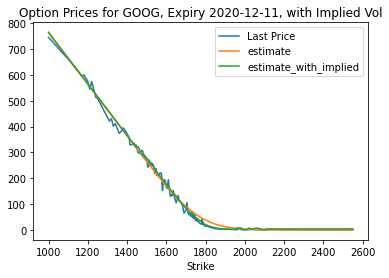

In [21]:
# if we use implied vol instead of historical vol, our estimate should improve

def calculate_prices_across_strikes(options_df, cur_stock_price, time_to_expiration, risk_free_rate, sigma):

    print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
    list_estimates = []

    strike_start_idx, strike_end_idx = 0, options_df.shape[0]

    # run BSM for different strikes
    for x in range(strike_start_idx,strike_end_idx):
#         print(options_df['Strike'][x])
        value_s = black_scholes(S = cur_stock_price, 
                                K = options_df['Strike'][x], 
                                T = time_to_expiration, 
                                r = risk_free_rate, 
                                sigma = options_df['Implied Volatility'][x])
        list_estimates.append(value_s)

    # merge the real and computed dataframes to compare results
    options_df['estimate_with_implied'] = list_estimates

    return options_df

df_estimate = calculate_prices_across_strikes(put_estimate_filtered, cur_stock_price, time_to_expiration, risk_free_rate, sigma)
df_estimate.plot(x='Strike',y=['Last Price','estimate','estimate_with_implied'], title='Option Prices for {}, Expiry {}, with Implied Vol'.format(ticker, expiration_datetime.date()))

count    137.000000
mean     -16.826372
std       26.276971
min      -98.773248
25%      -25.992334
50%       -7.857701
75%       -0.061643
max       33.213952
Name: estimate_with_implied_error, dtype: float64


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Estimate Percent Error Across Strikes (Filtered Strikes)'}, xlabel='Strike'>

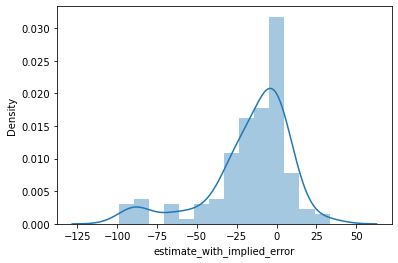

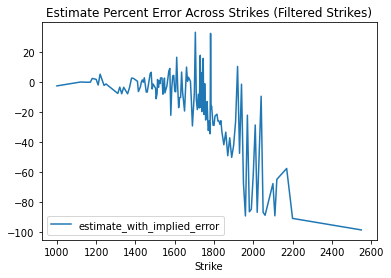

In [22]:

df_estimate['estimate_with_implied_error'] = ((df_estimate['Last Price'] - df_estimate['estimate_with_implied'])/df_estimate['estimate_with_implied'])*100
ax = sns.distplot(df_estimate['estimate_with_implied_error'])
print(df_estimate['estimate_with_implied_error'].describe())
put_estimate_filtered.plot(x='Strike',y='estimate_with_implied_error',title='Estimate Percent Error Across Strikes (Filtered Strikes)')


In [23]:
mse = np.sum((df_estimate['Last Price'] - df_estimate['estimate_with_implied'])**2) / df_estimate.shape[0]
rmse = np.sqrt(mse)

print(mse, rmse)

156.2410514173332 12.499642051568244


In [24]:
# how accurate is BSM for different expiration dates?

import os 

data_path = "/home/amao/options_data/2020-11-19 17:00:01.568118"

ticker = 'TSLA'
calls_data, puts_data = dict(), dict()

for filename in os.listdir(data_path):
    if ticker in filename:
        df = pd.read_csv(os.path.join(data_path, filename))
        if 'puts' in filename :
            puts_data[filename] = df
        elif 'calls' in filename:
            calls_data[filename] = df
        
print(len(calls_data), len(puts_data))

4 4


In [25]:
# stock_price_df = df

# for k,v in calls_data.items():
#     print(k, v.head())
#     bsm_estimate_df = calculate_prices_across_strikes(v, cur_stock_price, time_to_expiration, risk_free_rate, sigma):


In [26]:
# binomial tree
import math

sigma = .2
rfr = .02
delta_t = 1

u = math.exp(sigma * math.sqrt(delta_t))
d = math.exp(-sigma * math.sqrt(delta_t))
print('u and d:',u,d)

# a = math.exp(rfr * delta_t)
a = math.exp((rfr - .01) * delta_t)
p = (a - d)/(u - d)

print('p', p)


u and d: 1.2214027581601699 0.8187307530779818
p 0.47512469600943963


In [27]:
# N period binomial tree model

def price_option_european(S_0, u, d, K, option_type: str, num_periods: int):
    
    if num_periods == 0:
        if option_type == 'call':
            return max(S_0-K, 0)
        elif option_type == 'put':
            return max(K-S_0, 0)
    else:
        S_u = S_0 * u
        S_d = S_0 * d
        
        f_u = price_option_european(S_0 * u,u,d,K,option_type,num_periods-1)
        f_d = price_option_european(S_0 * d,u,d,K,option_type,num_periods-1)
        
#         print('f_u and f_d:', f_u, f_d)

        return math.exp(-rfr*delta_t) * (p*f_u + (1-p)*f_d)

S_0 = 200
K = 200
option_type = 'put'

for i in range(5):
    price = price_option_european(S_0, u, d, K, option_type, num_periods=i)
    print('price',price)
    

price 0
price 18.65195571686643
price 17.452716560268637
price 25.695678025946652
price 24.44307753439426


In [28]:
def price_option_american(S_0, u, d, K, option_type: str, num_periods: int):
    
    if num_periods == 0:
        if option_type == 'call':
            return max(S_0-K, 0)
        elif option_type == 'put':
            return max(K-S_0, 0)
    else:
        S_u = S_0 * u
        S_d = S_0 * d
        
        f_u = price_option_american(S_0 * u,u,d,K,option_type,num_periods-1)
        f_d = price_option_american(S_0 * d,u,d,K,option_type,num_periods-1)
        
        if option_type == 'call':
            f_u_early = max(S_u-K, 0)
            f_d_early = max(S_d-K, 0)
        elif option_type == 'put':
            f_u_early = max(K-S_u, 0)
            f_d_early = max(K-S_d, 0)
#         print('f_u,f_d,f_u_early,f_d_early:',f_u,f_d,f_u_early,f_d_early)
        f_u = max(f_u,f_u_early)
        f_d = max(f_u,f_d_early)
        
#         print('f_u and f_d:', f_u, f_d)

        return math.exp(-rfr*delta_t) * (p*f_u + (1-p)*f_d)

S_0 = 200
K = 200
option_type = 'put'

for i in range(5):
    price = price_option_american(S_0, u, d, K, option_type, num_periods=i)
    print('price',price)

price 0
price 18.65195571686643
price 18.65195571686643
price 18.65195571686643
price 18.65195571686643
